In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
import scipy
import time 
import tqdm

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel

from delfi.distribution.mixture import MoG
%matplotlib inline


## Calculate the exact NB posterior by numerical integration

### Do it for Poisson first to make sure it works in principle

In [2]:
# generate poisson data 
x = scipy.stats.poisson.rvs(mu=20., size=5)
k1 = 2
theta1 = 2
prior_lam = scipy.stats.gamma(a=k1, scale=theta1)

In [3]:
# lambdas for which to calculate the posterior values given the observed data 
lamps = np.linspace(1e-10, 50, 1000)

# deifne the integral function: likelihood times prior 
def integrant(l): 
    lp = np.prod(scipy.stats.poisson.pmf(k=x, mu=l)) * prior_lam.pdf(x=l)
    return lp

# calculate evidence once: entire range of lambdas integrated 
(px, err) = scipy.integrate.quad(integrant, a=0, b=40)

posts = []

# calculate product of likelihood and prior for every lambda, dived by evidence 
for l in lamps: 
    posts.append(np.prod(scipy.stats.poisson.pmf(k=x, mu=l)) * prior_lam.pdf(l) / px)

In [4]:
print('Numerical vs. analytical evidence: {}, {}'.format(px, poisson_evidence(x, k1, theta1)))

Numerical vs. analytical evidence: 2.5692112834503916e-09, 2.5692112386139106e-09


In [5]:
# get analytical gamma posterior 
k_post = k1 + np.sum(x)

# use the posterior given the summary stats, not the data vector 
scale_post = 1. / (5 + theta1**-1)

true_post_poisson = gamma(a=k_post, scale=scale_post)

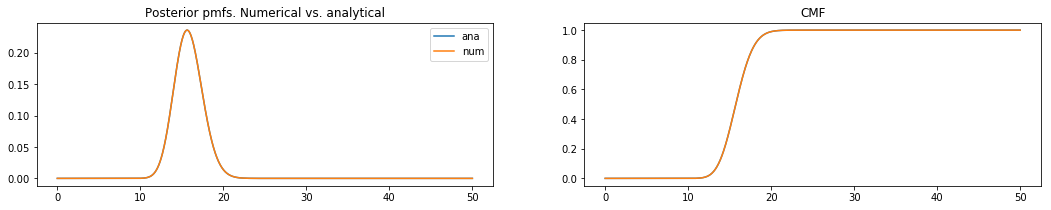

In [6]:
# compare with true posterior 
plt.figure(figsize=(18, 3))
posts_ana = true_post_poisson.pdf(x=lamps)
plt.subplot(121)
plt.plot(lamps, posts_ana, label='ana');
plt.plot(lamps, posts, label=('num'))
plt.title('Posterior pmfs. Numerical vs. analytical')
plt.legend();

plt.subplot(122)
plt.title('CMF')
dt = lamps[1] - lamps[0]
poisson_cmf = np.cumsum(posts) * dt
plt.plot(lamps, np.cumsum(posts_ana) * dt)
plt.plot(lamps, poisson_cmf);

## Characterize numerical posterior
When calculating the posterior numerically we obtain an arrray of pmf values. To characterize the distribution we want to sample from it and know the mean the variance. We can sample from using inverse transform sampling. 

- sample from a uniform distribution
- map the uniform samples to corresponding values of the desired distribution using the inverse CDF

In [7]:
n_samples = 10000
uniform_samples = scipy.stats.uniform.rvs(size=n_samples)

In [8]:
post_samples = []
for s in uniform_samples:
    # find idx in cmf 
    idx = np.where(poisson_cmf >= s)[0][0]
    # add the corresponding value 
    post_samples.append(lamps[idx])

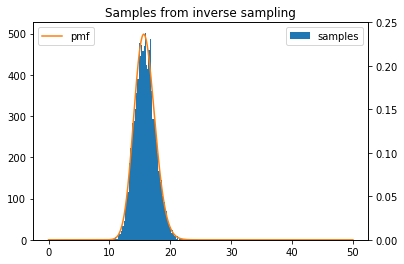

In [9]:
plt.title('Samples from inverse sampling')
plt.hist(post_samples, bins='auto', label='samples')
plt.legend()
plt.twinx()
plt.plot(lamps, posts, 'C1', label='pmf')
plt.legend(loc=2)
plt.ylim(0, .25);

In [10]:
print('sample mean and std: {:.3} +- {:.3}'.format(np.mean(post_samples), np.std(post_samples)))
print('analytical mean and std: {:.3} +- {:.3}'.format(true_post_poisson.mean(), true_post_poisson.std()))

sample mean and std: 15.8 +- 1.68
analytical mean and std: 15.8 +- 1.7


## Now for NB

In [26]:
# generate samples from indirect NB
k2 = 1.
theta2 = 1.0
k3 = 2.
theta3 = 2. 
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)
n_samples = 1
sample_size = 50
params, x = sample_poisson_gamma_mixture(prior_k, prior_theta, n_samples, sample_size)
params

array([[ 3.50396194,  6.08427728]])

In [27]:
# set up a grid 
prec = 1e-4
ks = np.linspace(prior_k.ppf(prec), prior_k.ppf(1 - prec), 100)
thetas = np.linspace(prior_theta.ppf(prec), prior_theta.ppf(1 - prec), 100)

In [28]:
# there is a function for the NB evidence integrant function: likelihood(x | params) * prior(params)
posts = np.zeros((ks.size, thetas.size))

# calculate likelihodd times prior for every grid value
with tqdm.tqdm(total=ks.size * thetas.size, disable=False) as pbar: 
    
    for i, k in enumerate(ks): 
        for j, th in enumerate(thetas): 
            r = k
            p = th / (1 + th)
            posts[i, j] = nb_evidence_integrant_direct(r, p, x, prior_k, prior_theta)
            pbar.update()

In [29]:
# calculate evidence once 
# px = calculate_nb_evidence(x, k2, theta2, k3, theta3)
px = np.trapz(np.trapz(posts, x=thetas, axis=1), x=ks, axis=0)

In [30]:
joint = posts / px

In [31]:
# find the maximum 
ids = np.unravel_index(np.argmax(joint.flatten()), dims=posts.shape)
# MAP estimate
print(r'MAP estimate: k={}, theta={}'.format(ks[ids[0]], thetas[ids[1]]))
# print(r'MAP estimate: k={}, theta={}'.format(ks[ids[0]], ps[ids[1]] / (1 - ps[ids[1]])))

MAP estimate: k=4.000507437121204, theta=5.721587922455076


## Plotting 

In [32]:
# Calculate CDF by taking cumsum on each axis 
s1 = np.cumsum(np.cumsum(joint, axis=0), axis=1)
# approximate cdf by sum times dt 
cdf = s1 / s1.max()

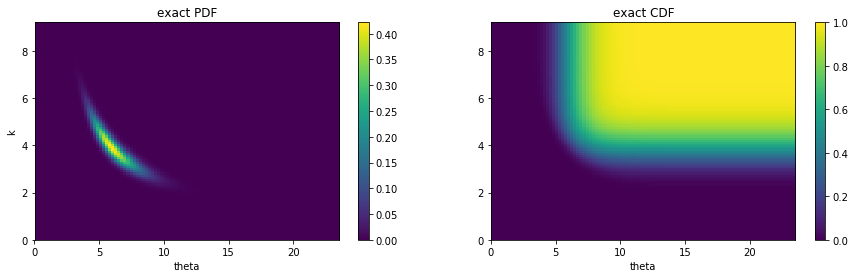

In [33]:
plt.figure(figsize=(15, 4))
plt.subplot(121) 
plt.imshow(joint, origin='lower', extent=[thetas.min(), thetas.max(), ks.min(), ks.max()], aspect='auto')
plt.colorbar();
plt.title('exact PDF')
plt.ylabel('k')
plt.xlabel('theta')
plt.subplot(122) 
plt.imshow(cdf, origin='lower', extent=[thetas.min(), thetas.max(), ks.min(), ks.max()], aspect='auto')
plt.title('exact CDF')
plt.colorbar()
plt.xlabel('theta');

In [35]:
# test summing of pdf 
dts = (ks[1] - ks[0]) * (thetas[1] - thetas[0])
print('pdf integral: ', joint.sum()  * dts)
print('CDF[0, 0]={:.3}, CDF[-1, -1]={:.3}'.format(cdf[0, 0], cdf[-1, -1]))

pdf integral:  1.00000113187
CDF[0, 0]=0.0, CDF[-1, -1]=1.0


## Inverse sampling 
This is not trivial in the 2D case with a joint CDF on $(X, Y)$. One solution seems to be to calculate the marginals of $X$ the the conditional $P(Y | X)$. Then sample $X$ using inverse sampling, and sample $Y$ using the conditional, conditioned on the sample from $X$. 

In [36]:
pk = np.trapz(joint, x=thetas, axis=1)
pk_cdf = np.cumsum(pk) * (ks[1] - ks[0])
pth = np.trapz(joint, x=ks, axis=0)
pth_cdf = np.cumsum(pth) * (thetas[1] - thetas[0])

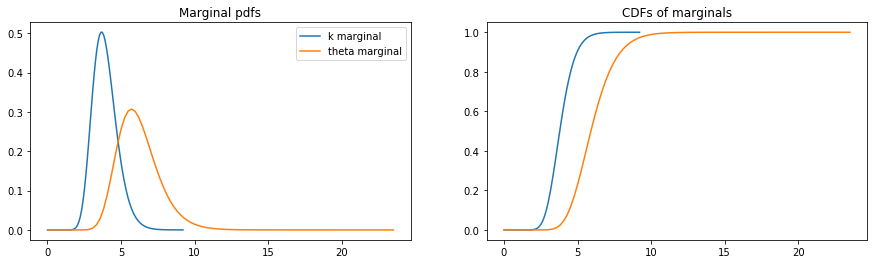

In [37]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.title('Marginal pdfs')
plt.plot(ks, pk, label='k marginal')
plt.plot(thetas, pth, label='theta marginal')
plt.legend(loc=0)

plt.subplot(122) 
plt.title('CDFs of marginals') 
plt.plot(ks, pk_cdf)
plt.plot(thetas, pth_cdf);

In [38]:
pk_given_th = np.zeros_like(joint)
for i, th in enumerate(thetas): 
    pk_given_th[:, i] = joint[:, i] / pth[i]

pth_given_k = np.zeros_like(joint)
for i, k in enumerate(ks): 
    pth_given_k[i, ] = joint[i, :] / pk[i]

# get the cdfs 
pth_given_k_cdf = np.cumsum(pth_given_k, axis=1) * (thetas[1] - thetas[0])
pk_given_th_cdf = np.cumsum(pk_given_th, axis=0) * (ks[1] - ks[0])

/Users/Jan/anaconda3/envs/mackelab/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


### First sample from marginal of $k$ using inverse sampling

In [39]:
# sample for uniform 
ns = 100000
uniform_samples = scipy.stats.uniform.rvs(size=ns)
# map to k 
k_samples = []
for s in uniform_samples:
    # find idx in cmf 
    idx = np.where(pk_cdf >= s)[0][0]
    # add the corresponding value 
    k_samples.append(ks[idx])

### Now use inverse sampling to sample from the conditional, given the $k$ samples 

In [40]:
# sample for uniform 
uniform_samples = scipy.stats.uniform.rvs(size=ns)
# map to k 
th_samples = []
for s, k in zip(uniform_samples, k_samples):
    # get the index of the k sample for conditioning 
    idx_k = np.where(ks >= k)[0][0]
    # find idx in conditional cmf 
    idx_u = np.where(pth_given_k_cdf[idx_k, ] >= s)[0][0]
    print
    # add the corresponding value 
    th_samples.append(thetas[idx_u])

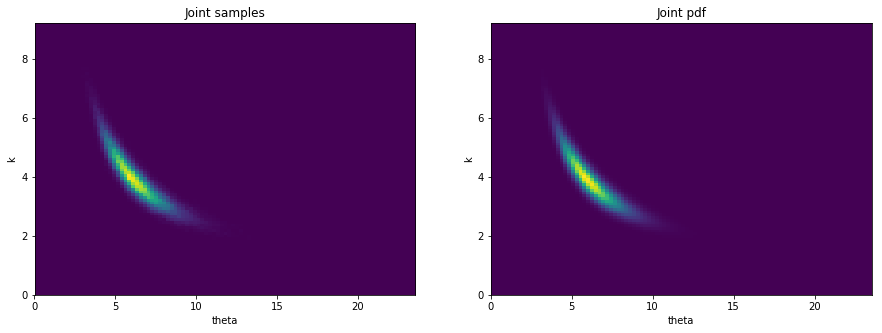

In [41]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Joint samples')
plt.hist2d(th_samples, k_samples, bins=[thetas, ks])
plt.ylabel('k')
plt.xlabel('theta')
plt.subplot(122)
plt.title('Joint pdf')
plt.imshow(joint, origin='lower', extent=[thetas.min(), thetas.max(), ks.min(), ks.max()], aspect='auto')
plt.ylabel('k')
plt.xlabel('theta');

In [42]:
m = np.mean(np.vstack((k_samples, th_samples)), axis=1)
cov = np.cov(np.vstack((k_samples, th_samples)))

In [43]:
print('Now we can estimate the mean and covariance of the posterior: \n m={}, \n cov={}'.format(m, cov))

Now we can estimate the mean and covariance of the posterior: 
 m=[ 3.91309667  6.19569135], 
 cov=[[ 0.68873939 -1.04102501]
 [-1.04102501  1.9760011 ]]


### Test the class that implements the above steps 

In [44]:
nb_post = NBExactPosterior(x, prior_k, prior_theta)
nb_post.calculat_exact_posterior(n_samples=100, prec=1e-4)

calculating posterior: 100%|██████████| 10000/10000 [00:03<00:00, 2862.53it/s]


In [45]:
samples = nb_post.gen(n_samples=10000)

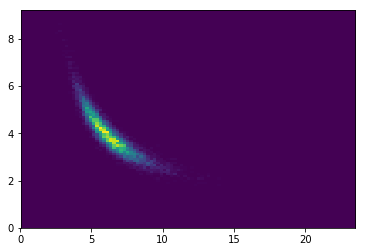

In [46]:
plt.hist2d(np.array(samples)[:, 1], np.array(samples)[:, 0], bins=[nb_post.thetas, nb_post.ks]);

In [47]:
print('Now we can estimate the mean and covariance of the posterior: \n m={}, \n cov={}'.format(nb_post.mean, 
                                                                                                nb_post.std))

Now we can estimate the mean and covariance of the posterior: 
 m=[ 3.92094585  6.18755012], 
 cov=[ 0.8384709  1.4136998]


## Posterior checks
Generate test many data and calculate the quantile and credible intervals of the posterior under this data. 

In [66]:
# generate test data 
n_samples = 500
sample_size = 100
params, x = sample_poisson_gamma_mixture(prior_k, prior_theta, n_samples, sample_size)

In [67]:
credible_intervals = np.arange(0.05, 1., 0.05)
cr_counts = np.zeros((3, credible_intervals.size))
qis = np.zeros((3, n_samples))

# for each test data, get the posterior 
with tqdm.tqdm(total=n_samples) as pbar:
    for ii, (p, xi) in enumerate(zip(params, x)): 
        # get the posterior 
        nb_post = NBExactPosterior(xi, prior_k, prior_theta)
        nb_post.calculat_exact_posterior(n_samples=100, prec=1e-4, verbose=False)
        [mk, mth] = nb_post.get_marginals()
        
        # get quantiles 
        qis[0, ii] = nb_post.cdf(p.reshape(1, -1))[0]
        qis[1, ii] = mk.cdf(p[0])[0]
        qis[2, ii] = mth.cdf(p[1])[0]

        # calculate credible intervals 
        cr_counts[0, ] += check_credible_regions(p.reshape(1, -1), nb_post.cdf, credible_intervals)
        cr_counts[1, ] += check_credible_regions(p[0], mk.cdf, credible_intervals)
        cr_counts[2, ] += check_credible_regions(p[1], mth.cdf, credible_intervals)
        pbar.update()

100%|██████████| 500/500 [23:10<00:00,  2.79s/it]


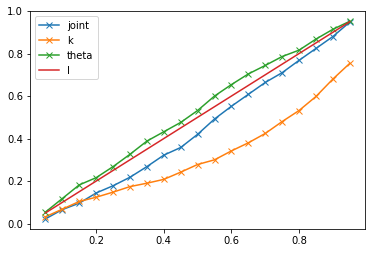

In [68]:
plt.plot(credible_intervals, cr_counts.T / n_samples, 'x-')
plt.plot(credible_intervals, credible_intervals, '-')
plt.legend(['joint', 'k', 'theta', 'I'])

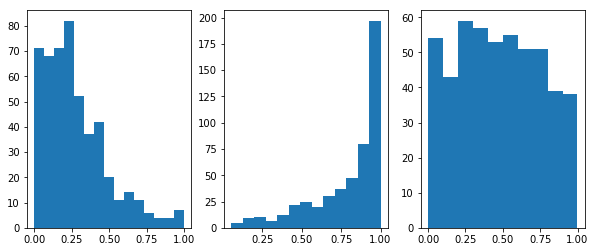

In [69]:
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(qis[i, ], bins='auto')